In [2]:
#dependencies
!pip install python-chess
import numpy as np
from chess.pgn import Game
from chess import Board
from typing import List
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import chess.pgn
import numpy as np
from tqdm import tqdm
import os
from torch.utils.data import random_split
from datasets import load_from_disk

In [3]:
#CNN

class ChessCNN(nn.Module):
    #model architecture: input -> conv2d -> relu -> conv2d -> relu -> conv2d -> relu -> flatten -> linear -> relu -> linear
    #input is an 8 x 8 matrix (representing a chess board) with 13 channels (12 for each unique piece and 1 for legal moves)
    #num_classes is the total number of unique moves in the dataset

    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(13,64,3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(64,64,3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(64,128,3,stride=1,padding=1)

        self.fc1 = nn.Linear(8*8*128,512)
        self.fc2 = nn.Linear(512,num_classes)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))

        x = self.flatten(x)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [4]:
#auxiliary functions

#returns a tensor representation of a chess board. Tensor is of shape (13,8,8)
#requires: board is of type Board
def board_to_tensor(board: Board):
    tensor = np.zeros((13,8,8))
    piece_map = board.piece_map()
    for square, piece in piece_map.items():
        row,col = divmod(square,8)
        piece_type = piece.piece_type - 1
        piece_color = 0 if piece.color else 6
        tensor[piece_type + piece_color, row, col] = 1

    legal_moves = board.legal_moves
    for move in legal_moves:
        to_square = move.to_square
        row_to, col_to = divmod(to_square,8)
        tensor[12,row_to,col_to] = 1

    return tensor

#returns an np.array of board tensors and an np.array of labels, where the board tensors are (13,8,8) and the labels are uci formatted strings.
#label y_i is the move that was played in position X_i
#requires: games is of type List[Game]
def games_to_input(games: List[Game]):
    X = []
    y = []
    for game in games:
        board = game.board()
        for move in game.mainline_moves():
            X.append(board_to_tensor(board))
            y.append(move.uci())
            board.push(move)
    return np.array(X, dtype=np.float32), np.array(y)

#returns an np.array of moves encoded as ints, a dict mapping moves to ints, and a dict mapping ints to moves.
#requires: moves is a list of uci formatted strings
def encode_moves(moves):
    unique_moves = list(set(moves))
    move_to_int = {move: int for int, move in enumerate(unique_moves)}
    int_to_move = {int: move for int, move in enumerate(unique_moves)}
    moves = [move_to_int[move] for move in moves]
    return np.array(moves, dtype=np.float32), move_to_int, int_to_move

def fen_and_moves_to_input(fen,moves):
    X = []
    y = []
    board = Board(fen)
    uci_list = moves.split()
    board.push(chess.Move.from_uci(uci_list[0]))
    uci_list = uci_list[1:]
    for uci in uci_list:
        tensor = board_to_tensor(board)
        label = uci
        X.append(tensor)
        y.append(label)
        board.push(chess.Move.from_uci(uci))
    return np.array(X, dtype=np.float32), np.array(y)

In [5]:
#custom dataset

#X are the board tensors and y are the labels
class ChessDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.X)

In [6]:
#training loop

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

print("loading games...")
max_games_per_file = 5000
games = []
for filename in os.listdir("./data"):
    if filename.endswith(".pgn"):
        pgn = open(f"./data/{filename}")
        i = 0
        while True and i<=max_games_per_file:
          game = chess.pgn.read_game(pgn)
          if game is None:
            break
          else:
            games.append(game)
          i += 1
print("games loaded")

max_games = 5000
games = games[:max_games]

print("converting games to input...")
X, y = games_to_input(games)
print("games converted")

print(f"input size of elite games: {len(X)}")

print("loading puzzle dataset")
puzzle_dset = load_from_disk("./data/chess_puzzles")
i = 0
for row in puzzle_dset:
  if i >= 400000:
    break
  fen = row["FEN"]
  moves = row["Moves"]
  X_puzzle, y_puzzle = fen_and_moves_to_input(fen,moves)
  np.concatenate((X,X_puzzle))
  np.concatenate((y,y_puzzle))
  i += (len(moves.split()) - 1)
print("puzzle dataset loading finished")


y, moves_to_int, int_to_moves = encode_moves(y)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

num_inputs = len(y)
num_classes = len(moves_to_int)
print(f"number of inputs = {num_inputs}")
print(f"number of classes = {num_classes}")

dataset = ChessDataset(X,y)

val_ratio = 0.1
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

model = ChessCNN(num_classes=num_classes).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
saved_val_loss = float('inf')  # initialize to track best val loss

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for input, label in tqdm(train_loader):
        input = input.to(device)
        label = label.to(device)
        output = model(input)
        loss = loss_fn(output, label)
        loss.backward()
        total_loss += loss.item() * input.size(0)
        optimizer.step()
        optimizer.zero_grad()
    saved_loss = total_loss / len(train_loader.dataset)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for input, label in tqdm(val_loader):
            input = input.to(device)
            label = label.to(device)
            output = model(input)
            loss = loss_fn(output, label)
            total_val_loss += loss.item() * input.size(0)
    temp_val_loss = total_val_loss / len(val_loader.dataset)

    if temp_val_loss < saved_val_loss:
        saved_val_loss = temp_val_loss
    else:
        print("Validation loss increased; stopping training.")
        break


    print(f"training loss for epoch{epoch} = {saved_loss}")
    print(f"validation loss for epoch{epoch} = {saved_val_loss}")

os.makedirs("./checkpoints", exist_ok=True)

torch.save(model.state_dict(), f"./checkpoints/num_epochs={num_epochs}_loss={saved_loss: .4f}.pth")

import json
metadata = {
    "num_classes": num_classes,
    "moves_to_int": moves_to_int,
    "int_to_moves": int_to_moves
}

with open(f"./checkpoints/metadata_num_epochs={num_epochs}.json", "w") as f:
    json.dump(metadata, f)

print("model and metadata saved.")

Using device:  cuda
loading games...
games loaded
converting games to input...
games converted
input size of elite games: 413419
loading puzzle dataset


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


813425
puzzle dataset loading finished
number of inputs = 813425
number of classes = 1903


100%|██████████| 2542/2542 [00:02<00:00, 854.41it/s]


training loss for epoch0 = 4.896689885278307
validation loss for epoch0 = 3.75677131365494


100%|██████████| 2542/2542 [00:03<00:00, 845.12it/s]


training loss for epoch1 = 3.2758620224050246
validation loss for epoch1 = 3.053987955437983


100%|██████████| 2542/2542 [00:03<00:00, 715.52it/s]


training loss for epoch2 = 2.783432362932987
validation loss for epoch2 = 2.789332453969078


100%|██████████| 2542/2542 [00:03<00:00, 678.10it/s]


training loss for epoch3 = 2.520880332486925
validation loss for epoch3 = 2.647401826645655


100%|██████████| 2542/2542 [00:02<00:00, 853.50it/s]


training loss for epoch4 = 2.3421567362831874
validation loss for epoch4 = 2.5580523377168767


100%|██████████| 2542/2542 [00:02<00:00, 891.36it/s]


training loss for epoch5 = 2.202479099301244
validation loss for epoch5 = 2.5153236721073804


100%|██████████| 2542/2542 [00:02<00:00, 897.69it/s]


training loss for epoch6 = 2.0837860159145025
validation loss for epoch6 = 2.488468866498806


100%|██████████| 2542/2542 [00:02<00:00, 893.67it/s]


training loss for epoch7 = 1.978472897868983
validation loss for epoch7 = 2.4845047757915815


100%|██████████| 2542/2542 [00:02<00:00, 889.46it/s]


training loss for epoch8 = 1.8819313044387367
validation loss for epoch8 = 2.479138712239217


100%|██████████| 2542/2542 [00:02<00:00, 886.34it/s]

Validation loss increased; stopping training.


In [38]:
board = chess.Board()
model.eval()

ChessCNN(
  (conv1): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1903, bias=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

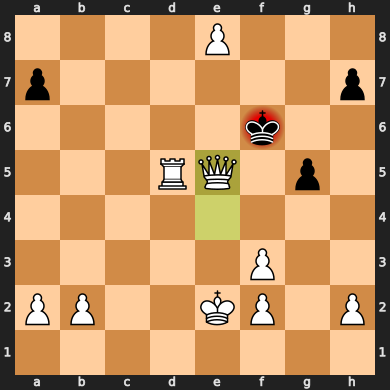

In [105]:
board.push(chess.Move.from_uci("e4e5"))
board

Predicted move: g6g5


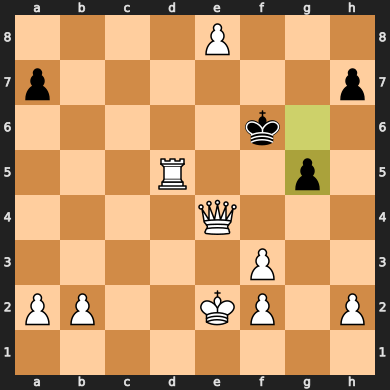

In [104]:
tensor = board_to_tensor(board)  # shape (13, 8, 8)
tensor = torch.tensor(tensor, dtype=torch.float32).unsqueeze(0)  # add batch dim
tensor = tensor.to(device)
with torch.no_grad():
  output = model(tensor)  # shape: [1, 1800]
  predicted_index = torch.argmax(output, dim=1).item()
predicted_move = int_to_moves[predicted_index]
print("Predicted move:", predicted_move)
move = chess.Move.from_uci(predicted_move)
board.push(move)
board
